In [1]:
# coding=utf-8
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os

In [2]:
# @hidden_cell
# The following code contains the credentials for a file in your IBM Cloud Object Storage.
# You might want to remove those credentials before you share your notebook.
credentials_1 = {
    'IAM_SERVICE_ID': 'iam-ServiceId-0d4c009c-7b91-4cb8-9dd2-3833bda252cd',
    'IBM_API_KEY_ID': 'FL0gB5b6dK-tM9qPPorOPFPm0E4uaJIKQoQJOGJ31Bwc',
    'ENDPOINT': 'https://s3.private.us.cloud-object-storage.appdomain.cloud',
    'IBM_AUTH_ENDPOINT': 'https://iam.cloud.ibm.com/oidc/token',
    'BUCKET': 'forecastmodel-donotdelete-pr-erpm129njwi9fr',
    'FILE': 'Sales data.xlsx'
}

from ibm_botocore.client import Config
import ibm_boto3

cos = ibm_boto3.client(service_name='s3',
                      ibm_api_key_id=credentials_1['IBM_API_KEY_ID'],
                      ibm_service_instance_id=credentials_1['IAM_SERVICE_ID'],
                      ibm_auth_endpoint=credentials_1['IBM_AUTH_ENDPOINT'],
                      config=Config(signature_version='oauth'),
                      endpoint_url=credentials_1['ENDPOINT'])
cos.download_file(Bucket=credentials_1['BUCKET'], Key='Sales data.xlsx', Filename='Sales data.xlsx')

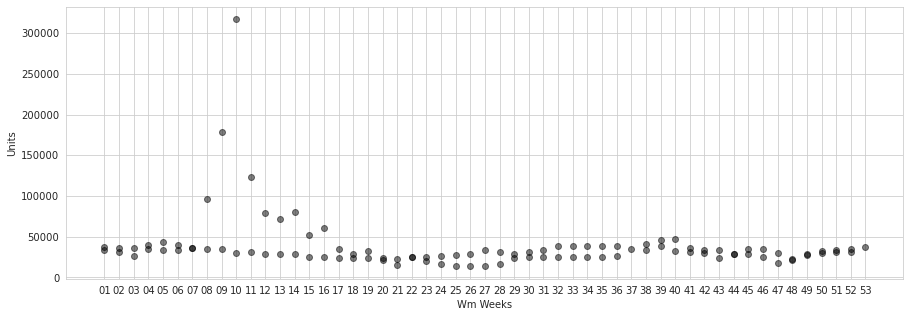

In [3]:
######### to see the whole picture past sales looks like ########
sales_df=[]
wkly_sales_df=[]
sales_data_file = 'Sales data.xlsx'
sales_df = pd.read_excel(sales_data_file, sheet_name = '8kz7e7x_742461972_F087662',skiprows=22)

# thre_instock = 0.95
# sales_data['Quantity'] = sales_data['Quantity']/sales_data['AVG Instock']*thre_instock

# # remove abnomal sale between  202008-202016
# abnomal_range = range(202008,202018)
# sales_data=sales_data[~sales_data['WM Week'].isin(abnomal_range)]

# last two digits are the walmart week


wkly_sales_df= sales_df.groupby(by=['WM Week'],as_index=False).agg({'POS Qty':'sum','Instock %':'mean','Avg Instock Store Count':'sum'}).rename(columns={'Avg Instock Store Count':'Total Store Count'})
wkly_sales_df['WkofYear'] = wkly_sales_df['WM Week'].astype("string").apply(lambda x:x[-2:])
wkly_sales_df['Year'] = wkly_sales_df['WM Week'].astype("string").apply(lambda x: int(x[:4]))
wkly_sales_df.sort_values(by = ['WkofYear'], inplace=True)

sns.set_style('whitegrid')
sns.set_palette('muted')

plt.figure(figsize=(15,5))
plt.scatter(x = wkly_sales_df['WkofYear'], y = wkly_sales_df['POS Qty'],c='Black',alpha = 0.5)

plt.xlabel('Wm Weeks')
plt.ylabel('Units')

plt.show()

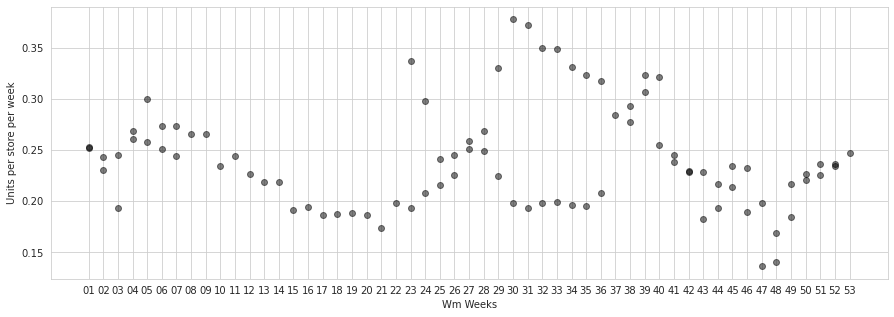

In [4]:
## remove abnomal sale between  202008-202022
abnomal_range = range(202008,202023)
wkly_sales_df=wkly_sales_df[~wkly_sales_df['WM Week'].isin(abnomal_range)]

## working on Avg units per store per week
wkly_sales_df['AVGUNITPSPW'] = wkly_sales_df['POS Qty']/wkly_sales_df['Total Store Count']


plt.figure(figsize=(15,5))
plt.scatter(x = wkly_sales_df['WkofYear'], y = wkly_sales_df['AVGUNITPSPW'],c='Black',alpha = 0.5)

plt.xlabel('Wm Weeks')
plt.ylabel('Units per store per week')

plt.show()

In [5]:
## Polynomial regression 

from sklearn.preprocessing import PolynomialFeatures
from sklearn import linear_model
import numpy as np
from sklearn.metrics import r2_score

X_train =np.asanyarray(wkly_sales_df[['WkofYear']])
y_train =np.asanyarray(wkly_sales_df[['AVGUNITPSPW']])

degree = 50
Best_d = 0
Best_score = 0
for d in range(2,degree+1):
    poly = PolynomialFeatures(degree=d)
    train_x_poly = poly.fit_transform(X_train)
    clf = linear_model.LinearRegression()
    clf.fit(train_x_poly, y_train)
    yhat_train = clf.predict(train_x_poly)
    score = r2_score(y_train,yhat_train)
    
    if score > Best_score:
        Best_d = d
        Best_score = score

print("Best degree:",Best_d)
print("Best_score:",Best_score)

poly = PolynomialFeatures(degree=Best_d)
train_x_poly = poly.fit_transform(X_train)
clf = linear_model.LinearRegression()
clf.fit(train_x_poly, y_train)

Best degree: 10
Best_score: 0.39001958914663526


LinearRegression()

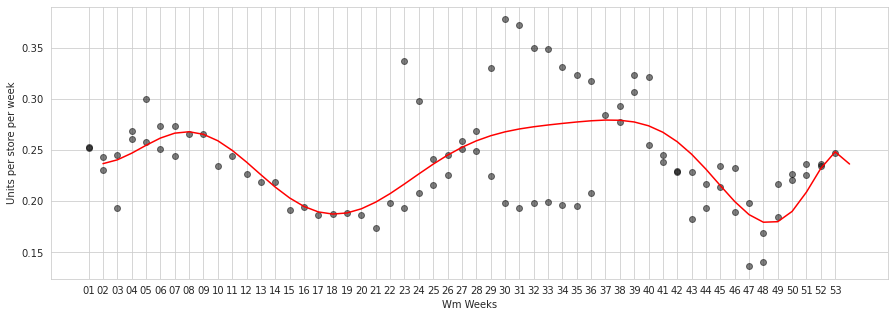

In [6]:
#### show the model and avg per store per week results ##

def polyfunc(coef_,intercept_,X):
    y = intercept_
    for i in range(1,len(coef_[0])):
        y = y + coef_[0][i]*np.power(X,i)
    return y

X = np.arange(1,54,1)
y = polyfunc(clf.coef_,clf.intercept_,X)


plt.figure(figsize=(15,5))
plt.scatter(x = wkly_sales_df['WkofYear'], y = wkly_sales_df['AVGUNITPSPW'],c='Black',alpha = 0.5)
plt.plot(X,y,'-r')
plt.xlabel('Wm Weeks')
plt.ylabel('Units per store per week')

plt.show()

In [7]:
### download and read Walmart forecast data ##
# @hidden_cell
# The following code contains the credentials for a file in your IBM Cloud Object Storage.
# You might want to remove those credentials before you share your notebook.
credentials_2 = {
    'IAM_SERVICE_ID': 'iam-ServiceId-0d4c009c-7b91-4cb8-9dd2-3833bda252cd',
    'IBM_API_KEY_ID': 'FL0gB5b6dK-tM9qPPorOPFPm0E4uaJIKQoQJOGJ31Bwc',
    'ENDPOINT': 'https://s3.private.us.cloud-object-storage.appdomain.cloud',
    'IBM_AUTH_ENDPOINT': 'https://iam.cloud.ibm.com/oidc/token',
    'BUCKET': 'forecastmodel-donotdelete-pr-erpm129njwi9fr',
    'FILE': 'FCST solids.xlsx'
}

from ibm_botocore.client import Config
import ibm_boto3

cos = ibm_boto3.client(service_name='s3',
                      ibm_api_key_id=credentials_1['IBM_API_KEY_ID'],
                      ibm_service_instance_id=credentials_1['IAM_SERVICE_ID'],
                      ibm_auth_endpoint=credentials_1['IBM_AUTH_ENDPOINT'],
                      config=Config(signature_version='oauth'),
                      endpoint_url=credentials_1['ENDPOINT'])
cos.download_file(Bucket=credentials_1['BUCKET'], Key='FCST solids.xlsx', Filename='FCST solids.xlsx')

In [8]:
fcst_df=[]
wkly_fcst_df=[]
fcst_data_file = 'FCST solids.xlsx'
fcst_df = pd.read_excel(fcst_data_file, sheet_name = '8kz7e7x_742625064_50E7BF9',skiprows=35)

In [9]:
## build DF for forecast
wkly_fcst_df = fcst_df.loc[:,'Week 01 Forecast':'Week 52 Forecast'].sum().reset_index()
wkly_fcst_df.rename(columns={'index': 'WkofYear', 0:'Fcst Units'}, inplace = True)
wkly_fcst_df['WkofYear'] = wkly_fcst_df['WkofYear'].apply(lambda x : x.split(" ")[1])

## sales counter part
Curr_week = 202136
Total_Curr_store_count = int(wkly_sales_df[wkly_sales_df['WM Week']==Curr_week]['Total Store Count'])

## model to predict total units
X = np.arange(1,54,1)
y = polyfunc(clf.coef_,clf.intercept_,X) * Total_Curr_store_count



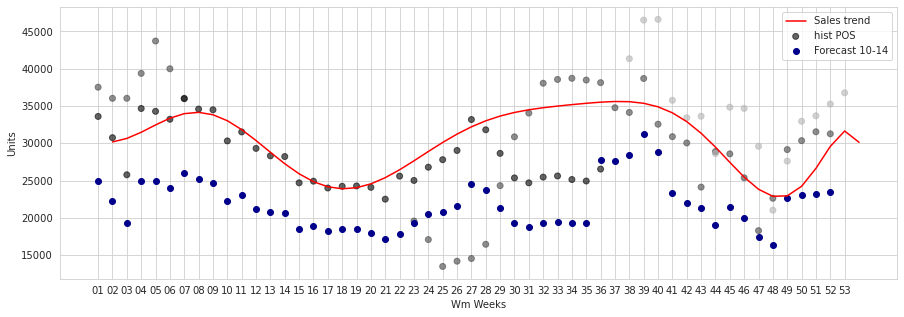

In [10]:
plt.figure(figsize=(15,5))

colormap = {2019:"#B4B4B4",2020:'#474747',2021:'#000000'}
color = wkly_sales_df['Year'].apply(lambda x:colormap[x])
plt.scatter(x = wkly_sales_df['WkofYear'], y = wkly_sales_df['POS Qty'],c=color,alpha = 0.6,label="hist POS")
plt.scatter(x = wkly_fcst_df['WkofYear'], y = wkly_fcst_df['Fcst Units'],c='DarkBlue', label="Forecast 10-14")
plt.plot(X,y,'-r', label="Sales trend")
plt.xlabel('Wm Weeks')
plt.ylabel('Units')
plt.legend()

plt.show()

In [11]:

# @hidden_cell
# The following code contains the credentials for a file in your IBM Cloud Object Storage.
# You might want to remove those credentials before you share your notebook.
credentials_3 = {
    'IAM_SERVICE_ID': 'iam-ServiceId-0d4c009c-7b91-4cb8-9dd2-3833bda252cd',
    'IBM_API_KEY_ID': 'FL0gB5b6dK-tM9qPPorOPFPm0E4uaJIKQoQJOGJ31Bwc',
    'ENDPOINT': 'https://s3.private.us.cloud-object-storage.appdomain.cloud',
    'IBM_AUTH_ENDPOINT': 'https://iam.cloud.ibm.com/oidc/token',
    'BUCKET': 'forecastmodel-donotdelete-pr-erpm129njwi9fr',
    'FILE': 'FCST solid 2.xlsx'
}
cos = ibm_boto3.client(service_name='s3',
                      ibm_api_key_id=credentials_1['IBM_API_KEY_ID'],
                      ibm_service_instance_id=credentials_1['IAM_SERVICE_ID'],
                      ibm_auth_endpoint=credentials_1['IBM_AUTH_ENDPOINT'],
                      config=Config(signature_version='oauth'),
                      endpoint_url=credentials_1['ENDPOINT'])
cos.download_file(Bucket=credentials_1['BUCKET'], Key='FCST solid 2.xlsx', Filename='FCST solid 2.xlsx')

In [20]:
fcst_df_2=[]
wkly_fcst_df_2=[]
fcst_data_file = 'FCST solid 2.xlsx'
fcst_df_2 = pd.read_excel(fcst_data_file, sheet_name = '8kz7e7x_743912945_A6ED77E',skiprows=34)


In [24]:
## build DF for forecast
wkly_fcst_df_2 = fcst_df_2.loc[:,'Week 01 Forecast':'Week 52 Forecast'].sum().reset_index()
wkly_fcst_df_2.rename(columns={'index': 'WkofYear', 0:'Fcst Units'}, inplace = True)
wkly_fcst_df_2['WkofYear'] = wkly_fcst_df_2['WkofYear'].apply(lambda x : x.split(" ")[1])

## sales counter part
Curr_week = 202136
Total_Curr_store_count = int(wkly_sales_df[wkly_sales_df['WM Week']==Curr_week]['Total Store Count'])

## model to predict total units
X = np.arange(1,54,1)
y = polyfunc(clf.coef_,clf.intercept_,X) * Total_Curr_store_count

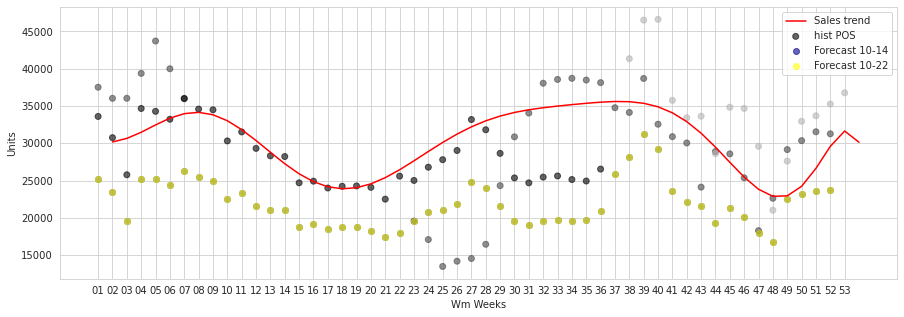

In [27]:
plt.figure(figsize=(15,5))

colormap = {2019:"#B4B4B4",2020:'#474747',2021:'#000000'}
color = wkly_sales_df['Year'].apply(lambda x:colormap[x])
plt.scatter(x = wkly_sales_df['WkofYear'], y = wkly_sales_df['POS Qty'],c=color,alpha = 0.6,label="hist POS")
plt.scatter(x = wkly_fcst_df['WkofYear'], y = wkly_fcst_df['Fcst Units'],c='DarkBlue', alpha=0.6, label="Forecast 10-14")
plt.scatter(x = wkly_fcst_df_2['WkofYear'], y = wkly_fcst_df_2['Fcst Units'],c='Yellow', alpha=0.6, label="Forecast 10-22")
plt.plot(X,y,'-r', label="Sales trend")
plt.xlabel('Wm Weeks')
plt.ylabel('Units')
plt.legend()

plt.show()